#Pytorch

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import math

Definimos algunas variables

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

nf = 128

Device: cuda


##Generador

Se pudo agregar capas de BatchNormalization y capas de Dropout

In [ ]:
class generator_model(torch.nn.Module):
  def __init__(self,latent_dim=100):
    super(generator_model,self).__init__()
    self.latent_dim = latent_dim

    #Base
    self.conv1 = torch.nn.ConvTranspose2d(latent_dim,nf*8,4,1,0,bias=False)
    self.bn1 = torch.nn.BatchNorm2d(nf*8)
    self.conv2 = torch.nn.ConvTranspose2d(nf*8,nf*4,4,2,1,bias=False)
    self.bn2 = torch.nn.BatchNorm2d(nf*4)
    self.conv3 = torch.nn.ConvTranspose2d(nf*4,nf*2,4,2,1,bias=False)
    self.bn3 = torch.nn.BatchNorm2d(nf*2)
    self.conv4 = torch.nn.ConvTranspose2d(nf*2,1,4,2,1,bias=False)

  def forward(self,x):
    x = x.view(-1,self.latent_dim,1,1)
    x = self.conv1(x)
    x = self.bn1(x)
    x = torch.nn.functional.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = torch.nn.functional.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = torch.nn.functional.relu(x)
    x = self.conv4(x)
    x = torch.tanh(x)
    return x

  def np_to_tensor(self,x):
    return torch.from_numpy(x).float().to(device)

  def tensor_to_np(self,x):
    return x.detach().cpu().numpy()

##Discriminador

In [ ]:
class discriminator_model(torch.nn.Module):
  def __init__(self):
    super(discriminator_model,self).__init__()
    #Base
    self.l1 = torch.nn.Conv2d(1,nf*2,4,2,1,bias=False)
    self.bn1 = torch.nn.BatchNorm2d(nf*2)
    self.l2 = torch.nn.Conv2d(nf*2,nf*4,4,2,1,bias=False)
    self.bn2 = torch.nn.BatchNorm2d(nf*4)
    self.l3 = torch.nn.Conv2d(nf*4,nf*8,4,2,1,bias=False)
    self.bn3 = torch.nn.BatchNorm2d(nf*8)
    self.output = torch.nn.Conv2d(nf*8,1,4,1,0,bias=False)

  def forward(self,x):
    x = self.l1(x)
    x = self.bn1(x)
    x = torch.nn.functional.leaky_relu(x,0.2)
    x = self.l2(x)
    x = self.bn2(x)
    x = torch.nn.functional.leaky_relu(x,0.2)
    x = self.l3(x)
    x = self.bn3(x)
    x = torch.nn.functional.leaky_relu(x,0.2)
    x = self.output(x)
    x = torch.sigmoid(x)
    return x

  def np_to_tensor(self,x):
    return torch.from_numpy(x).float().to(device)

  def tensor_to_np(self,x):
    return x.detach().cpu().numpy()

HIPERPARÁMETROS

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

In [ ]:
torch.manual_seed(0)

generator = generator_model()
discriminator = discriminator_model()

generator = generator.to(device)
discriminator = discriminator.to(device)

generator_optimizer = torch.optim.Adam(generator.parameters(),lr=0.0002)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),lr=0.0002)


Probamos ambos modelos

In [ ]:
from torchsummary import summary

#summary(generator,(100,))
summary(discriminator, (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 16, 16]           4,096
       BatchNorm2d-2          [-1, 256, 16, 16]             512
            Conv2d-3            [-1, 512, 8, 8]       2,097,152
       BatchNorm2d-4            [-1, 512, 8, 8]           1,024
            Conv2d-5           [-1, 1024, 4, 4]       8,388,608
       BatchNorm2d-6           [-1, 1024, 4, 4]           2,048
            Conv2d-7              [-1, 1, 1, 1]          16,384
Total params: 10,509,824
Trainable params: 10,509,824
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.75
Params size (MB): 40.09
Estimated Total Size (MB): 41.85
----------------------------------------------------------------


(32, 32)


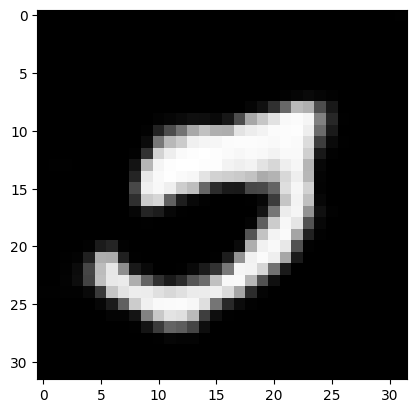

In [ ]:
generator.eval()
ruido = torch.randn(1,100).to(device)
img = generator(ruido)
img = generator.tensor_to_np(img.squeeze())
print(img.shape)
#plt.imshow(img[0].transpose(1,2,0))
plt.imshow(img,cmap='gray')


In [ ]:
print(ruido)

tensor([[-0.3382, -0.6635,  0.5568, -0.8797, -0.5877,  1.6940,  0.2711, -0.1301,
         -0.2842, -0.0706, -0.0792, -0.0108,  0.7242, -0.5921,  0.9847, -0.4325,
          0.8634, -1.5339,  0.2834, -0.2825,  0.9170, -0.7713, -2.1987,  0.0743,
          1.1668, -1.9222, -0.6238,  0.3458,  0.1033, -1.5827, -0.4374, -0.4551,
          0.4623,  0.3675,  0.6459, -0.8774,  0.8880, -0.4742,  0.3227,  1.2209,
         -1.2489,  1.5208, -0.0916, -0.0263,  1.1683,  0.6870,  2.0280,  1.2922,
          2.1660,  0.7713,  1.4527,  0.0870, -0.8281,  0.0072, -1.0798, -1.9066,
          0.4797, -0.3049,  0.7161,  0.8539,  0.8560, -1.0717,  0.3993,  1.2714,
         -0.0472,  1.0148,  1.4969, -0.3368,  0.6311,  1.0623,  1.4307, -0.1495,
         -0.3065,  0.9252, -0.0283,  0.0752,  0.4420, -0.0365, -0.1990,  1.4727,
          0.1623, -0.3348,  1.3724,  0.5091,  1.2665, -0.7079,  0.5985, -0.0734,
         -0.7816, -1.0080, -0.5075,  0.6506, -0.5840,  0.3976, -0.9570, -0.1762,
          0.1967,  0.1165, -

In [ ]:
discriminator.eval()
generator.eval()
ruido = torch.randn(1,100).to(device)
img = generator(ruido)
salida = discriminator(img)

print(salida)


tensor([[0.5240]], device='cuda:0', grad_fn=<SigmoidBackward0>)


#Cargamos el dataset

In [ ]:
# Visualizar una muestra
import matplotlib.pyplot as plt

def show_sample(dataset, index):
    image, label = dataset[index]
    image = image.squeeze()  # Eliminar la dimensión del canal (1x28x28 -> 28x28)
    plt.imshow(image, cmap='gray')
    plt.title(f"Etiqueta: {label}")
    plt.axis('off')
    plt.show()

In [ ]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

transformaciones = transforms.Compose([transforms.Resize((32,32)),
                                       transforms.CenterCrop(32),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5), (0.5))])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transformaciones)


#dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.Resize((32,32)),
#                                                                                                   transforms.CenterCrop(32),
#                                                                                                   transforms.ToTensor(),
#                                                                                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
#                                                                                                   ))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


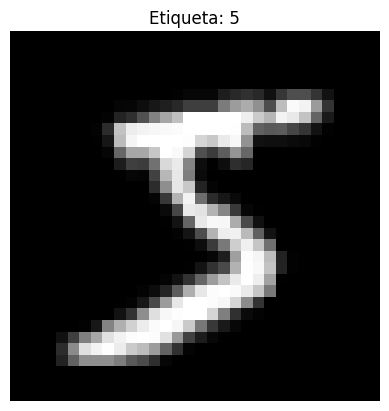

In [ ]:
show_sample(dataset, index=0)

Función de pérdidas

In [ ]:
criterion = torch.nn.BCELoss()

In [ ]:
ruidos = torch.randn(128, 100, 1, 1, device=device)
ruidos.shape
ruidos = ruidos.squeeze()
ruidos.shape
imagenes_falsas = generator(ruidos)
imagenes_falsas.shape

torch.Size([128, 1, 32, 32])

In [ ]:
import torchvision.utils as vutils

img_list = []
G_losses = []
D_losses = []
iters = 0

#generator.train()
#discriminator.train()

for epoch in range(EPOCHS):

  for i, data in enumerate(dataloader,0):

    #discriminator.train()
    #generator.eval()

    discriminator_optimizer.zero_grad()
    real = data[0].to(device)
    batch_size = real.size(0)
    labels = torch.full((batch_size,), 1, dtype=torch.float, device=device)
    output = discriminator(real).view(-1)
    errD_real = criterion(output, labels)
    errD_real.backward()
    D_x = output.mean().item()


    noise = torch.randn(batch_size, 100, 1, 1, device=device)
    noise = noise.squeeze()
    fake = generator(noise)
    labels.fill_(0)
    output = discriminator(fake.detach()).view(-1)
    errD_fake = criterion(output, labels)
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    errD = errD_real + errD_fake
    discriminator_optimizer.step()

    #generator.train()
    #discriminator.eval()

    generator_optimizer.zero_grad()
    labels.fill_(1)
    output = discriminator(fake).view(-1)
    errG = criterion(output, labels)
    errG.backward()
    D_G_z2 = output.mean().item()
    generator_optimizer.step()

    if i % 50 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
      % (epoch, EPOCHS, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    G_losses.append(errG.item())
    D_losses.append(errD.item())

    if (iters % 500 == 0) or ((epoch == EPOCHS-1) and (i == len(dataloader)-1)):
      with torch.no_grad():
        fake = generator(noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    iters += 1




[0/10][0/469]	Loss_D: 1.4559	Loss_G: 7.3754	D(x): 0.6156	D(G(z)): 0.6088 / 0.0008
[0/10][50/469]	Loss_D: 0.0003	Loss_G: 9.1631	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[0/10][100/469]	Loss_D: 0.0003	Loss_G: 8.8863	D(x): 0.9999	D(G(z)): 0.0002 / 0.0001
[0/10][150/469]	Loss_D: 0.0002	Loss_G: 10.0319	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/10][200/469]	Loss_D: 0.0000	Loss_G: 10.6204	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][250/469]	Loss_D: 0.0003	Loss_G: 8.8394	D(x): 1.0000	D(G(z)): 0.0002 / 0.0001
[0/10][300/469]	Loss_D: 0.0002	Loss_G: 9.1599	D(x): 1.0000	D(G(z)): 0.0002 / 0.0001
[0/10][350/469]	Loss_D: 0.0002	Loss_G: 9.3709	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[0/10][400/469]	Loss_D: 0.0001	Loss_G: 10.5796	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][450/469]	Loss_D: 0.0000	Loss_G: 11.3867	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/10][0/469]	Loss_D: 0.0001	Loss_G: 10.3368	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/10][50/469]	Loss_D: 0.0000	Loss_G: 10.9080	D(x): 1.0000	D(G(z)): 0.0000 /

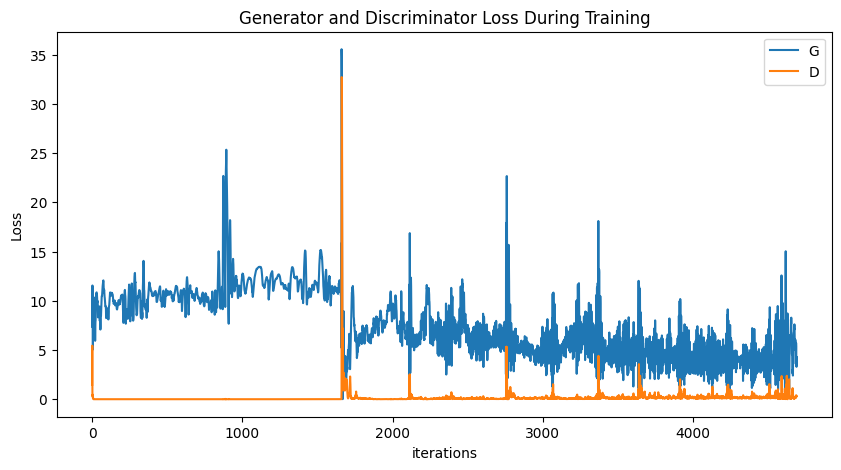

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

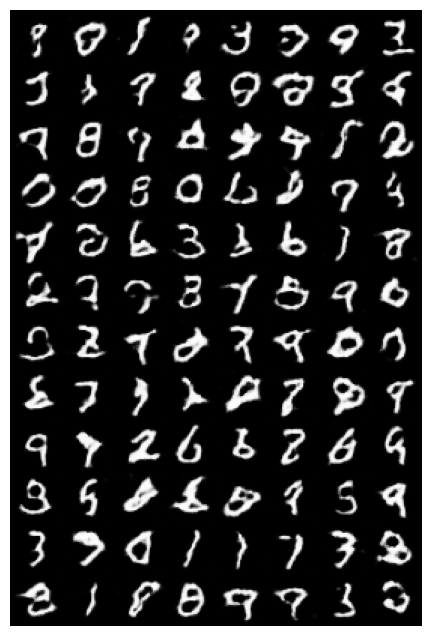

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())